In [ ]:
from config import *
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
lemmatizer = WordNetLemmatizer() 
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
glove_path = "/content/drive/My Drive/Fake news classifier/glove.6B.100d.txt"
train_path = "/content/drive/My Drive/Fake news classifier/train.csv"
test_path = "/content/drive/My Drive/Fake news classifier/test.csv"

In [ ]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [ ]:
print(df_train.shape)
print(df_test.shape)

(20800, 5)
(5200, 4)


In [ ]:

print("missing values in train \n",df_train.isna().sum())
print("missing values in test \n",df_test.isna().sum())

#**Preprocessing**

In [ ]:
#Preprocessing pipeline
def drop_missing(df):
  df.dropna(how = 'any', inplace=True)
  df.reset_index(drop = True, inplace=True)
  return df

def drop_cols(df):
    if('id' in df.columns):
      df.drop(['id', 'author', 'text'], axis = 1, inplace=True) 
    return df

def basic_cleaning(df):
  df = df.apply(lambda x: x.astype(str).str.lower()) #apply to all rows, lambda is a temporary function
  df = df.apply(lambda x: x.astype(str).str.replace('\n', ""))#remove linebreaks
  return df

def extensive_cleaning(df):
  #cleaning done using regular expressions
  df = df.apply(lambda x: x.astype(str).str.replace(r'http[\w:/\.]+','URL'))
  #urls beginning wiht http followed by any word character set (\w) or (:) or (.) or (%20)
  df = df.apply(lambda x: x.astype(str).str.replace(r'(\S)+\.com((\S)+)?','URL')) 
  df = df.apply(lambda x: x.astype(str).str.replace(r'[^\.\w\s]','')) #remove everything but characters and punctuation
  df = df.apply(lambda x: x.astype(str).str.replace(r'\.','.')) #replace multiple periods with a single one
  df = df.apply(lambda x: x.astype(str).str.replace(r'\s\s+',' ')) #replace multiple white space with a single one
  return df

def lemmatize(X):
  corpus = []
  for i in range(len(X)):
      news = X[i]
      news = news.split()
      news = [lemmatizer.lemmatize(word) for word in news if not word in stopwords.words('english')]
      news = ' '.join(news)
      corpus.append(news)
  return corpus

In [ ]:
df_train = drop_missing(df_train)
df_train = drop_cols(df_train)
df_test = drop_cols(df_test)
display(df_train.tail())
display(df_test.tail())

In [ ]:
df_train = basic_cleaning(df_train)
df_test = basic_cleaning(df_test)

In [ ]:
df_train = extensive_cleaning(df_train)
df_test = extensive_cleaning(df_test)

In [ ]:
train_labels = df_train['label'].astype('int').to_numpy()
train_title = df_train['title']
test_title = df_test['title']
display(train_labels.shape)
display(train_title.shape)
display(test_title.shape)


(18285,)

(18285,)

(5200,)

In [ ]:
train_corpus = lemmatize(train_title)
test_corpus = lemmatize(test_title)

#**Glove dictionary**

In [ ]:
# Extract glove dictionary
word2glove = {}
glove_words = []
with open(glove_path, 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        #values are in list of string format so convert to vector
        vector = np.asarray(values[1:], "float32")
        word2glove[word] = vector
        glove_words.append(word)
EMBEDDING_DIM = len(vector)

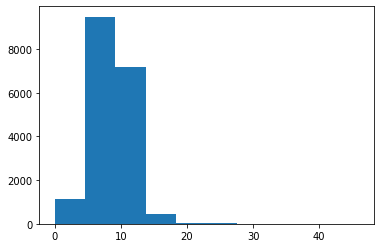

20408
4044
16735
73
3673
16810
82.00215601724814


In [ ]:
corpus = train_corpus
#PREPARE GLOVE DICTIONARY FOR ENCODING NEWS--->
all_text = ' '.join(corpus)
from collections import Counter
words = all_text.split()
corpus_u_words_counter = Counter(words).most_common() #tuple of unique words, frequency
corpus_u_words_frequent = [word[0] for word in corpus_u_words_counter if word[1]> WORD_FREQUENCY] #keep only words which have occured more than 5 times for deciding about words not in glove later
corpus_u_words = [word for word, count in corpus_u_words_counter]

glove_words_index = dict(zip(glove_words, range(len(glove_words))))

#filter corpus words --> words in glove / not in glove.. use a boolean array to reduce comparisons
#glove_word_index is a hash table --> quick search
is_corpus_word_in_glove = np.array([w in glove_words_index for w in corpus_u_words])
words_in_glove = [word for word, is_true in zip(corpus_u_words, is_corpus_word_in_glove)  if is_true]
words_not_in_glove = [word for word, is_true in zip(corpus_u_words, is_corpus_word_in_glove)  if not is_true]
freq_words_not_in_glove = [w for w in words_not_in_glove if w in corpus_u_words_frequent]

# create the dictionary of glove weights
word2index = dict(zip(words_in_glove, range(len(words_in_glove)))) #we have weights for this! --> fixed
freq_words_not_in_glove_index = dict(zip(freq_words_not_in_glove, range(len(word2index), len(word2index)+len(freq_words_not_in_glove)))) #we have to learn weights for this --> train embedding
word2index = dict(**word2index, **freq_words_not_in_glove_index) 
#creating dummy word for oov words
word2index['<Other>'] = len(word2index) #all others are accounted as other tag and one common embedding is learnt --> train embedding

#histogram of title word length
plt.hist([len(t.split()) for t in corpus])
plt.show()
#MAX_NEWS_LENGTH = 25 (from config)

#creating a dummy word for padding
word2index['<PAD>'] = len(word2index)


print(len(corpus_u_words))
print(len(corpus_u_words_frequent))
print(len(words_in_glove))
print(len(freq_words_not_in_glove))
print(len(words_not_in_glove))
print(len(word2index))
print(100*len(words_in_glove)/len(corpus_u_words))




#**Encoding news title**

In [ ]:
def encode_news(corpus):
  encoded_news = []
  for news in corpus:
    int_news = [word2index[word] if word in word2index else word2index['<Other>'] for word in news.split()] 
    encoded_news.append(int_news)
  return encoded_news

In [ ]:
def pad_news(encoded_news):
  for i, news in zip(range(len(encoded_news)), encoded_news):
    if (len(news) < MAX_NEWS_LENGTH):
      encoded_news[i] = [word2index['<PAD>']]*(MAX_NEWS_LENGTH - len(news)) + news
    elif (len(news) > MAX_NEWS_LENGTH):
      encoded_news[i] = news[:MAX_NEWS_LENGTH]
    else:
      continue
  return encoded_news

In [ ]:
encoded_train_news = encode_news(train_corpus)
encoded_test_news = encode_news(test_corpus)

In [ ]:
encoded_train_news = pad_news(encoded_train_news)
encoded_test_news = pad_news(encoded_test_news)

In [ ]:
train_input = np.array(encoded_train_news)
train_label = train_labels.reshape(-1, 1)
test_input = np.array(encoded_test_news)

#**Model training**

In [ ]:
print(train_input.shape)
print(train_label.shape)

(18285, 25)
(18285, 1)


In [ ]:
from keras.engine.topology import Layer
import keras.backend as K
from keras import initializers

class Embedding2(Layer):

    def __init__(self, input_dim, output_dim, fixed_weights, embeddings_initializer='uniform', 
                 input_length=None, **kwargs):
        kwargs['dtype'] = 'int32'
        if 'input_shape' not in kwargs:
            if input_length:
                kwargs['input_shape'] = (input_length,)
            else:
                kwargs['input_shape'] = (None,)
        super(Embedding2, self).__init__(**kwargs)
    
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embeddings_initializer = embeddings_initializer
        self.fixed_weights = fixed_weights
        self.num_trainable = input_dim - len(fixed_weights)
        self.input_length = input_length
        
        w_mean = fixed_weights.mean(axis=0)
        w_std = fixed_weights.std(axis=0)
        self.variable_weights = w_mean + w_std*np.random.randn(self.num_trainable, output_dim)

    def build(self, input_shape, name='embeddings'):        
        fixed_weight = K.variable(self.fixed_weights, name=name+'_fixed')
        variable_weight = K.variable(self.variable_weights, name=name+'_var')
        
        self._trainable_weights.append(variable_weight)
        self._non_trainable_weights.append(fixed_weight)
        
        self.embeddings = K.concatenate([fixed_weight, variable_weight], axis=0)
        
        self.built = True

    def call(self, inputs):
        if K.dtype(inputs) != 'int32':
            inputs = K.cast(inputs, 'int32')
        out = K.gather(self.embeddings, inputs)
        return out

    def compute_output_shape(self, input_shape):
        if not self.input_length:
            input_length = input_shape[1]
        else:
            input_length = self.input_length
        return (input_shape[0], input_length, self.output_dim)

In [ ]:

model = Sequential()
model.add(Embedding2(len(word2index) + 1, EMBEDDING_DIM,
                    fixed_weights=np.array([word2glove[w] for w in words_in_glove]))) 
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(MAX_NEWS_LENGTH, dropout=0.25, recurrent_dropout=0.1, kernel_regularizer=regularizers.l2(0.01), 
                             recurrent_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding2_16 (Embedding2)   (None, None, 100)         1681100   
_________________________________________________________________
dropout_29 (Dropout)         (None, None, 100)         0         
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 50)                25200     
_________________________________________________________________
batch_normalization_5 (Batch (None, 50)                200       
_________________________________________________________________
dropout_30 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 51        
Total params: 1,706,551
Trainable params: 32,951
Non-trainable params: 1,673,600
______________________________________

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(train_input, train_label, test_size= test_size, random_state=42)
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))

Epoch 1/10
115/115 [==============================] - 10s 84ms/step - loss: 2.1524 - accuracy: 0.8227 - val_loss: 1.3977 - val_accuracy: 0.7391
Epoch 2/10
115/115 [==============================] - 9s 80ms/step - loss: 0.9669 - accuracy: 0.8826 - val_loss: 0.8230 - val_accuracy: 0.8791
Epoch 3/10
115/115 [==============================] - 9s 78ms/step - loss: 0.6746 - accuracy: 0.8882 - val_loss: 0.6168 - val_accuracy: 0.8846
Epoch 4/10
115/115 [==============================] - 9s 78ms/step - loss: 0.5415 - accuracy: 0.8914 - val_loss: 0.4855 - val_accuracy: 0.8890
Epoch 5/10
115/115 [==============================] - 12s 101ms/step - loss: 0.4534 - accuracy: 0.8920 - val_loss: 0.4163 - val_accuracy: 0.8925
Epoch 6/10
115/115 [==============================] - 9s 79ms/step - loss: 0.3902 - accuracy: 0.8953 - val_loss: 0.3564 - val_accuracy: 0.8917
Epoch 7/10
115/115 [==============================] - 9s 79ms/step - loss: 0.3460 - accuracy: 0.8939 - val_loss: 0.3173 - val_accuracy: 0.8

In [ ]:
def plot_learningcurve(history):
  epoch_range = range(1,epochs+ 1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc = 'upper right')
  plt.show()

  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc = 'upper right')
  plt.show()

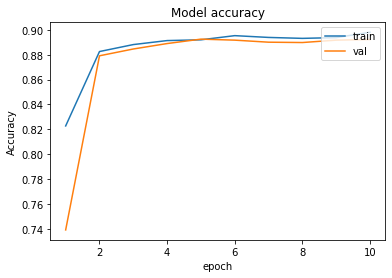

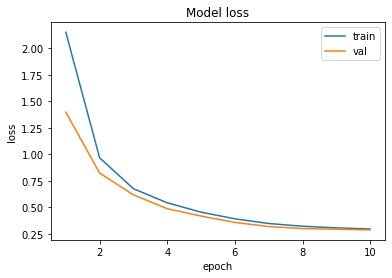

In [ ]:
plot_learningcurve(history)

In [ ]:
history.history

{'accuracy': [0.924254834651947,
  0.9261006116867065,
  0.9297921657562256,
  0.9320481419563293,
  0.9333469867706299,
  0.9362182021141052,
  0.9352611303329468,
  0.9390894174575806,
  0.9414820671081543,
  0.9412086606025696],
 'loss': [0.17408990859985352,
  0.16910891234874725,
  0.16582918167114258,
  0.16294755041599274,
  0.15916723012924194,
  0.15297414362430573,
  0.1518249213695526,
  0.1456872969865799,
  0.1451379954814911,
  0.1413700431585312],
 'val_accuracy': [0.9165983200073242,
  0.9174186587333679,
  0.9193328022956848,
  0.9182389974594116,
  0.9119496941566467,
  0.9209734797477722,
  0.9185124635696411,
  0.9239814281463623,
  0.911129355430603,
  0.9228876233100891],
 'val_loss': [0.18964941799640656,
  0.1852683424949646,
  0.18734565377235413,
  0.18857192993164062,
  0.22424659132957458,
  0.18370412290096283,
  0.20596085488796234,
  0.177399680018425,
  0.25719261169433594,
  0.1915874034166336]}

In [ ]:
test_id = df_test['id']

In [ ]:
df_test = drop_cols(df_test)

In [ ]:
df_test.isnull().sum()

title    0
text     0
dtype: int64

In [ ]:
test_input.shape

(5200, 25)

In [ ]:
predictions = model.predict_classes(test_input)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
predictions


array([[0],
       [1],
       [1],
       ...,
       [0],
       [1],
       [0]], dtype=int32)

In [ ]:
df_test['preds'] = predictions

In [ ]:
df_test.iloc[[0]].to_numpy()

array([['specter of trump loosens tongues if not purse strings in silicon valley the new york times']],
      dtype=object)

In [ ]:
submission = pd.DataFrame({'id':test_id, 'label':predictions.flatten()})
submission.shape

(5200, 2)

In [ ]:
submission.to_csv('submission.csv',index=False)


In [ ]:
data = {'title':['Fighting for life in Syrias vicious civil war If there is meaning to the word courage, said a Syrian journalist, it is represented by the Civil Defense. Also known as the White Helmets, the trained force of 3,000 rescue workers offer Syrian civilians their only hope', 'How a Texas Ranger convinced serial killer Samuel Little to confess to murdering 93 people', 'Scientists are using MRI scans to reveal the physical makeup of our thoughts and feelings','Artificial intelligence is preserving our ability to converse with Holocaust survivors even after they die', 'Trump Tempers Fears About Wildfires By Drinking Cup Of Flames']} 

In [ ]:
our_df = pd.DataFrame(data) 
our_df.iloc[[0]].to_numpy()


array([['Fighting for life in Syrias vicious civil war If there is meaning to the word courage, said a Syrian journalist, it is represented by the Civil Defense. Also known as the White Helmets, the trained force of 3,000 rescue workers offer Syrian civilians their only hope']],
      dtype=object)

In [ ]:
our_df = drop_missing(our_df)
our_df = basic_cleaning(our_df)
our_df = extensive_cleaning(our_df)
print(our_df.iloc[[0]].to_numpy())
our_title = our_df['title']

[['fighting for life in syrias vicious civil war if there is meaning to the word courage said a syrian journalist it is represented by the civil defense. also known as the white helmets the trained force of 3000 rescue workers offer syrian civilians their only hope']]


In [ ]:
our_corpus = lemmatize(our_title)
encoded_our_news = encode_news(our_corpus)
encoded_our_news = pad_news(encoded_our_news)
our_input = np.array(encoded_our_news)
print(our_input.shape)
our_input

(5, 25)


array([[  539,    61,    42, 12884,   464,    14,  5680,   446,  8168,
          337,   133,   492,  9257,   464, 16808,  2050,  2340,    29,
         6260, 16808,   148,  3674,  2275,   350,   498],
       [16809, 16809, 16809, 16809, 16809, 16809, 16809, 16809, 16809,
        16809, 16809, 16809, 16809, 16809,   121,  5188,  9396,  3238,
          981, 10206,   570, 16808,  2746,  4206,    46],
       [16809, 16809, 16809, 16809, 16809, 16809, 16809, 16809, 16809,
        16809, 16809, 16809, 16809, 16809, 16809, 16809,   407,   460,
         9423,  4904,   825,  3787,  2860,   764,  1690],
       [16809, 16809, 16809, 16809, 16809, 16809, 16809, 16809, 16809,
        16809, 16809, 16809, 16809, 16809, 16809, 16809,  3262,   519,
         8978,  6664, 16808,  1936,  1710,   237,   521],
       [16809, 16809, 16809, 16809, 16809, 16809, 16809, 16809, 16809,
        16809, 16809, 16809, 16809, 16809, 16809, 16809, 16809, 16809,
            3, 11819,   232,  3591,  1827,  2852,  8652]])

In [ ]:
model.predict_classes(our_input)

array([[1],
       [1],
       [1],
       [1],
       [1]], dtype=int32)